In [1]:
from river.datasets import ImageSegments
from river.preprocessing import MinMaxScaler
from river.tree import HoeffdingTreeClassifier
from deep_river.classification import Classifier
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.manifold import TSNE

random.seed(0)

### Create Stream

In [2]:
stream_size = 10_000

x, y = list(zip(*ImageSegments()))
x = np.array(x)
y = np.array(y)

# Divide classes into two task specific sets
task_classes = [
    ["brickface", "window", "cement"],
    ["sky", "foliage", "path", "grass"],
]

# Divide all samples into their specific tasks
data_train = []
data_test = []
for classes_t in task_classes:
    x_t = np.concatenate([x[y == c] for c in classes_t])
    y_t = np.concatenate([330 * [c] for c in classes_t])
    x_train, x_test, y_train, y_test = train_test_split(
        x_t, y_t, test_size=0.25, stratify=y_t
    )
    x_train, y_train = resample(
        x_train, y_train, n_samples=int(stream_size / 2), stratify=y_train
    )
    data_train.append(list(zip(x_train, y_train)))
    data_test.append(list(zip(x_test, y_test)))

data_train = data_train[0] + data_train[1]

### Visualize Data

In [3]:
classnames = task_classes[0] + task_classes[1]
tsne = TSNE(init="pca", learning_rate="auto", n_jobs=-1)
x_array = np.array([list(x_i.values()) for x_i in x])
x_viz = tsne.fit_transform(x_array)

/Users/cedrickulbach/Documents/Environments/deep-river/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


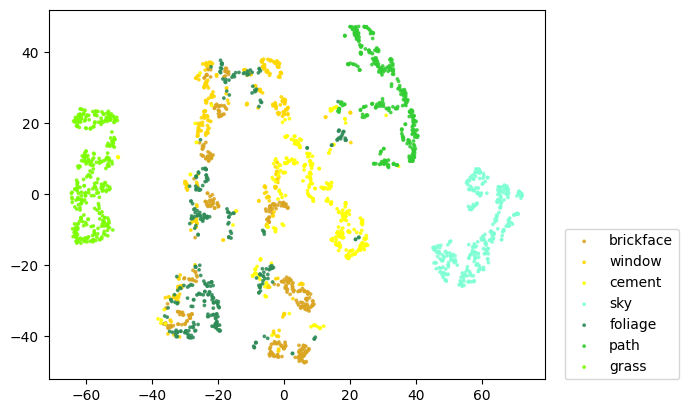

In [4]:
fig, ax = plt.subplots()
cm = [
    "goldenrod",
    "gold",
    "yellow",
    "aquamarine",
    "seagreen",
    "limegreen",
    "lawngreen",
]
for c_idx, x_c in enumerate([x_viz[y == c] for c in classnames]):
    scatter = ax.scatter(
        x_c[:, 0],
        x_c[:, 1],
        c=len(x_c) * [cm[c_idx]],
        s=3,
        alpha=0.8,
        label=classnames[c_idx],
    )

ax.legend(loc=(1.04, 0))

### Define evaluation procedure

In [5]:
# Define function to calculate accuracy on testing data for each task
def get_test_accuracy(model, data_test):
    results = []
    for data_test_i in data_test:
        ys = []
        y_preds = []
        for x_test, y_test in data_test_i:
            ys.append(y_test)
            y_preds.append(model.predict_one(x_test))
        accuracy = accuracy_score(ys, y_preds)
        results.append(accuracy)
    return results


# Define training and testing loop
def eval_separate_testing(model, data_train, data_test):
    scaler = MinMaxScaler()
    step = 0
    steps = []
    results = [[] for task in data_test]
    for x, y in tqdm(data_train):
        step += 1
        scaler.learn_one(x)
        x = scaler.transform_one(x)
        model.learn_one(x, y)

        if step % 100 == 0:
            test_accuracies = get_test_accuracy(model, data_test)
            for idx, accuracy in enumerate(test_accuracies):
                results[idx].append(accuracy)
            steps.append(step)
    return steps, results

## Evaluate Classifiers

In [6]:
# Evaluate a simple MLP classifier
class SimpleMLP(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.hidden1 = nn.Linear(n_features, 30)
        self.logits = nn.Linear(30, 7)

    def forward(self, x):
        h = torch.relu(self.hidden1(x))
        return self.logits(h)


mlp = Classifier(
    SimpleMLP,
    loss_fn="binary_cross_entropy_with_logits",
    optimizer_fn="sgd",
    lr=0.05,
    seed=42,
)
steps, results_mlp = eval_separate_testing(mlp, data_train, data_test)

  0%|                                                                                                                                                                                                                    | 0/10000 [00:00<?, ?it/s]

  0%|                                                                                                                                                                                                          | 1/10000 [00:01<3:05:01,  1.11s/it]

  1%|██                                                                                                                                                                                                       | 105/10000 [00:01<01:22, 119.32it/s]

  2%|████▏                                                                                                                                                                                                    | 211/10000 [00:01<00:39, 250.89it/s]

  3%|██████▎                                                                                                                                                                                                  | 313/10000 [00:01<00:25, 378.82it/s]

  4%|████████▍                                                                                                                                                                                                | 417/10000 [00:01<00:18, 505.66it/s]

  5%|██████████▊                                                                                                                                                                                              | 536/10000 [00:01<00:14, 652.98it/s]

  6%|█████████████                                                                                                                                                                                            | 650/10000 [00:01<00:12, 767.14it/s]

  8%|███████████████▎                                                                                                                                                                                         | 764/10000 [00:01<00:10, 860.22it/s]

  9%|█████████████████▌                                                                                                                                                                                       | 873/10000 [00:01<00:10, 912.65it/s]

 10%|███████████████████▊                                                                                                                                                                                     | 987/10000 [00:02<00:09, 973.55it/s]

 11%|█████████████████████▉                                                                                                                                                                                  | 1097/10000 [00:02<00:09, 986.37it/s]

 12%|████████████████████████                                                                                                                                                                                | 1205/10000 [00:02<00:10, 876.86it/s]

 13%|██████████████████████████                                                                                                                                                                              | 1301/10000 [00:02<00:09, 892.19it/s]

 14%|████████████████████████████                                                                                                                                                                            | 1403/10000 [00:02<00:09, 925.71it/s]

 15%|██████████████████████████████▍                                                                                                                                                                        | 1527/10000 [00:02<00:08, 1012.56it/s]

 16%|████████████████████████████████▌                                                                                                                                                                      | 1636/10000 [00:02<00:08, 1032.75it/s]

 17%|██████████████████████████████████▋                                                                                                                                                                    | 1743/10000 [00:02<00:08, 1031.74it/s]

 18%|████████████████████████████████████▊                                                                                                                                                                  | 1849/10000 [00:02<00:08, 1001.68it/s]

 20%|███████████████████████████████████████                                                                                                                                                                 | 1951/10000 [00:03<00:08, 998.04it/s]

 21%|█████████████████████████████████████████                                                                                                                                                               | 2052/10000 [00:03<00:08, 983.11it/s]

 22%|███████████████████████████████████████████                                                                                                                                                             | 2152/10000 [00:03<00:08, 967.63it/s]

 22%|█████████████████████████████████████████████                                                                                                                                                           | 2250/10000 [00:03<00:08, 935.96it/s]

 23%|██████████████████████████████████████████████▉                                                                                                                                                         | 2345/10000 [00:03<00:08, 914.97it/s]

 24%|████████████████████████████████████████████████▋                                                                                                                                                       | 2437/10000 [00:03<00:08, 898.75it/s]

 25%|██████████████████████████████████████████████████▌                                                                                                                                                     | 2528/10000 [00:03<00:08, 892.89it/s]

 26%|████████████████████████████████████████████████████▎                                                                                                                                                   | 2618/10000 [00:03<00:08, 885.78it/s]

 27%|██████████████████████████████████████████████████████▏                                                                                                                                                 | 2707/10000 [00:03<00:08, 862.90it/s]

 28%|████████████████████████████████████████████████████████                                                                                                                                                | 2800/10000 [00:03<00:08, 862.43it/s]

 29%|█████████████████████████████████████████████████████████▉                                                                                                                                              | 2900/10000 [00:04<00:07, 890.50it/s]

 30%|████████████████████████████████████████████████████████████                                                                                                                                            | 3000/10000 [00:04<00:07, 911.13it/s]

 31%|██████████████████████████████████████████████████████████████▏                                                                                                                                         | 3110/10000 [00:04<00:07, 965.12it/s]

 32%|████████████████████████████████████████████████████████████████▎                                                                                                                                       | 3218/10000 [00:04<00:06, 998.54it/s]

 33%|██████████████████████████████████████████████████████████████████▏                                                                                                                                    | 3327/10000 [00:04<00:06, 1025.31it/s]

 35%|████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 3452/10000 [00:04<00:06, 1090.62it/s]

 36%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                | 3567/10000 [00:04<00:05, 1107.30it/s]

 37%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 3678/10000 [00:04<00:05, 1079.57it/s]

 38%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 3787/10000 [00:04<00:06, 1025.41it/s]

 39%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 3891/10000 [00:05<00:06, 1005.47it/s]

 40%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 3993/10000 [00:05<00:06, 987.95it/s]

 41%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 4100/10000 [00:05<00:06, 885.70it/s]

 42%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 4200/10000 [00:05<00:06, 911.82it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 4300/10000 [00:05<00:06, 930.64it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 4408/10000 [00:05<00:05, 971.09it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 4514/10000 [00:05<00:05, 996.30it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 4632/10000 [00:05<00:05, 1048.32it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 4738/10000 [00:05<00:05, 1049.60it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 4852/10000 [00:05<00:04, 1075.19it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 4961/10000 [00:06<00:04, 1077.38it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 5070/10000 [00:06<00:04, 1062.70it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 5189/10000 [00:06<00:04, 1099.68it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 5300/10000 [00:06<00:05, 939.01it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 5405/10000 [00:06<00:04, 967.45it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 5528/10000 [00:06<00:04, 1038.84it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 5648/10000 [00:06<00:04, 1084.04it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 5759/10000 [00:06<00:03, 1089.12it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 5870/10000 [00:06<00:03, 1090.09it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 5988/10000 [00:07<00:03, 1115.63it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 6101/10000 [00:07<00:04, 965.63it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 6205/10000 [00:07<00:03, 985.15it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 6312/10000 [00:07<00:03, 1007.90it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 6420/10000 [00:07<00:03, 1027.84it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 6532/10000 [00:07<00:03, 1053.96it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 6652/10000 [00:07<00:03, 1095.29it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 6766/10000 [00:07<00:02, 1107.37it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 6878/10000 [00:07<00:02, 1090.91it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 6990/10000 [00:08<00:02, 1098.71it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 7101/10000 [00:08<00:03, 930.00it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 7200/10000 [00:08<00:03, 906.73it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 7308/10000 [00:08<00:02, 952.12it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 7430/10000 [00:08<00:02, 1024.80it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 7555/10000 [00:08<00:02, 1088.02it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 7667/10000 [00:08<00:02, 1018.86it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 7772/10000 [00:08<00:02, 1004.14it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7875/10000 [00:08<00:02, 1004.94it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 7977/10000 [00:09<00:02, 1005.66it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 8079/10000 [00:09<00:01, 1003.63it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 8198/10000 [00:09<00:01, 1056.76it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 8305/10000 [00:09<00:01, 911.61it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 8400/10000 [00:09<00:01, 906.49it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 8504/10000 [00:09<00:01, 941.33it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 8620/10000 [00:09<00:01, 1001.38it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 8739/10000 [00:09<00:01, 1054.98it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8847/10000 [00:09<00:01, 1033.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 8956/10000 [00:10<00:00, 1048.64it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 9062/10000 [00:10<00:00, 989.53it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 9163/10000 [00:10<00:00, 988.73it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 9263/10000 [00:10<00:00, 984.32it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 9363/10000 [00:10<00:00, 952.09it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9459/10000 [00:10<00:00, 947.93it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9555/10000 [00:10<00:00, 947.58it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 9651/10000 [00:10<00:00, 911.47it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9743/10000 [00:10<00:00, 895.22it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9858/10000 [00:10<00:00, 967.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 9971/10000 [00:11<00:00, 1013.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 897.84it/s]

In [7]:
# Evaluate a Hoeffding Tree classifier
tree = HoeffdingTreeClassifier(tau=0.05)
steps, results_tree = eval_separate_testing(tree, data_train, data_test)

  0%|                                                                                                                                                                                                                    | 0/10000 [00:00<?, ?it/s]

  3%|██████                                                                                                                                                                                                  | 300/10000 [00:00<00:04, 2327.89it/s]

  6%|███████████                                                                                                                                                                                             | 553/10000 [00:00<00:03, 2434.01it/s]

  8%|████████████████                                                                                                                                                                                        | 800/10000 [00:00<00:04, 2152.73it/s]

 11%|█████████████████████▉                                                                                                                                                                                 | 1100/10000 [00:00<00:04, 2210.99it/s]

 14%|███████████████████████████▊                                                                                                                                                                           | 1400/10000 [00:00<00:03, 2209.89it/s]

 17%|████████████████████████████████▉                                                                                                                                                                      | 1656/10000 [00:00<00:03, 2309.32it/s]

 19%|█████████████████████████████████████▊                                                                                                                                                                 | 1900/10000 [00:00<00:03, 2197.23it/s]

 22%|███████████████████████████████████████████▊                                                                                                                                                           | 2200/10000 [00:00<00:03, 2231.62it/s]

 25%|█████████████████████████████████████████████████▊                                                                                                                                                     | 2500/10000 [00:01<00:03, 2247.76it/s]

 28%|███████████████████████████████████████████████████████▋                                                                                                                                               | 2800/10000 [00:01<00:03, 2253.67it/s]

 31%|█████████████████████████████████████████████████████████████▋                                                                                                                                         | 3100/10000 [00:01<00:03, 2247.76it/s]

 33%|██████████████████████████████████████████████████████████████████▍                                                                                                                                    | 3340/10000 [00:01<00:02, 2285.53it/s]

 36%|███████████████████████████████████████████████████████████████████████                                                                                                                                | 3570/10000 [00:01<00:02, 2252.41it/s]

 38%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 3796/10000 [00:01<00:02, 2225.17it/s]

 40%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 4019/10000 [00:01<00:02, 2014.16it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 4300/10000 [00:01<00:02, 2073.34it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 4565/10000 [00:02<00:02, 2222.30it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 4800/10000 [00:02<00:02, 2109.78it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 5027/10000 [00:02<00:02, 2151.45it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 5245/10000 [00:02<00:02, 1703.54it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 5431/10000 [00:02<00:03, 1458.49it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 5592/10000 [00:02<00:02, 1483.88it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 5752/10000 [00:02<00:03, 1292.38it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 5892/10000 [00:03<00:03, 1300.43it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 6030/10000 [00:03<00:03, 1090.71it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 6149/10000 [00:03<00:03, 1091.93it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 6265/10000 [00:03<00:03, 1106.72it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 6400/10000 [00:03<00:03, 994.45it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 6558/10000 [00:03<00:03, 1131.78it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 6690/10000 [00:03<00:02, 1178.69it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 6815/10000 [00:03<00:03, 1009.50it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 6948/10000 [00:04<00:02, 1086.75it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 7095/10000 [00:04<00:02, 1184.65it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 7221/10000 [00:04<00:02, 1014.72it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 7383/10000 [00:04<00:02, 1161.98it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 7509/10000 [00:04<00:02, 1001.03it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 7655/10000 [00:04<00:02, 1109.91it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 7800/10000 [00:04<00:02, 1028.58it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7950/10000 [00:04<00:01, 1140.21it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 8095/10000 [00:05<00:01, 1218.03it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 8225/10000 [00:05<00:01, 1042.29it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 8393/10000 [00:05<00:01, 1196.26it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 8523/10000 [00:05<00:01, 1048.99it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8686/10000 [00:05<00:01, 1187.96it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8815/10000 [00:05<00:01, 1018.92it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 8998/10000 [00:05<00:00, 1208.22it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 9132/10000 [00:06<00:00, 1070.77it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 9281/10000 [00:06<00:00, 1169.23it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9409/10000 [00:06<00:00, 1016.70it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9571/10000 [00:06<00:00, 1157.76it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 9700/10000 [00:06<00:00, 1022.64it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9862/10000 [00:06<00:00, 1162.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1041.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1457.08it/s]

### Visualize Accuracy over Timesteps

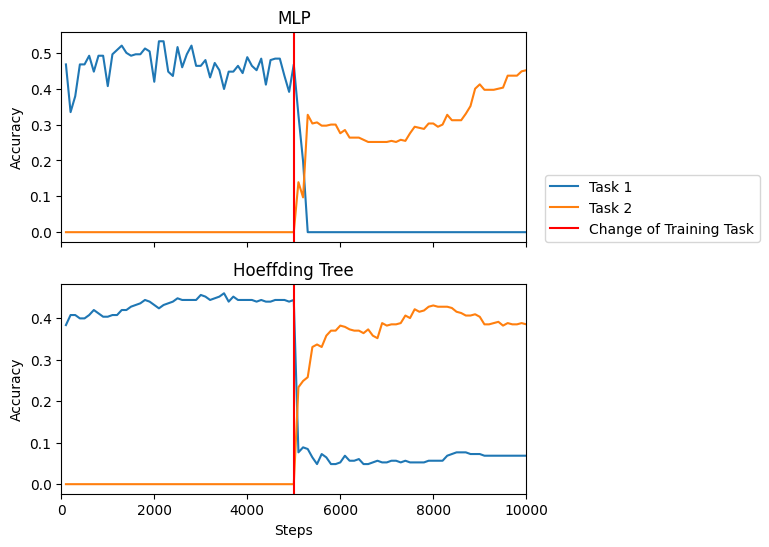

In [8]:
fig, axs = plt.subplots(nrows=2, figsize=(6, 6), sharex=True)
results = {"MLP": results_mlp, "Hoeffding Tree": results_tree}
for model_idx, (model_name, model_results) in enumerate(results.items()):
    ax = axs[model_idx]
    ax.plot(steps, model_results[0], label="Task 1")
    ax.plot(steps, model_results[1], label="Task 2")
    ax.axvline(5000, c="red", label="Change of Training Task")
    ax.set_ylabel("Accuracy")
    ax.set_title(model_name)
axs[-1].set_xlabel("Steps")
axs[-1].set_xlim(0, 10000)
axs[0].legend(loc=(1.04, 0))